In [1]:
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm, trange

## load dump file

In [2]:
def load_lammps_dump(filename):
    with open(filename, 'r') as file:
        lines = file.readlines()

    # Find the number of particles
    for i, line in enumerate(lines):
        if line.startswith('ITEM: NUMBER OF ATOMS'):
            num_particles = int(lines[i+1].strip())
            break
        
        # Find the box dimensions
    for i, line in enumerate(lines):
        if line.startswith('ITEM: BOX BOUNDS'):
            box_bounds = [list(map(float, bounds.split())) for bounds in lines[i+1:i+4]]
            break

    # Find the starting line of the atomic positions
    start_lines = []
    for i, line in enumerate(lines):
        if line.startswith('ITEM: ATOMS'):
            start_line = i + 1
            start_lines.append(start_line)

    # Initialize arrays to store the data
    ntime = len(start_lines)
    positions = np.zeros((ntime, num_particles, 3))
    atom_ids = np.zeros(num_particles, dtype=int)
    atom_types = np.zeros(num_particles, dtype=int)
    
    # atom id and type
    start_line_0 = start_lines[0]
    for i in range(num_particles):
        line = lines[start_line_0+i]
        data = line.split()
        atom_ids[i] = int(data[0])
        atom_types[i] = int(data[1])

    # Parse the atomic positions, atom IDs, and atom types
    for it, start_line_t in tqdm(enumerate(start_lines)):
        for i in range(num_particles):
            line = lines[start_line_t+i]
            data = line.split()
            positions[it, i, :] = [float(data[2]), float(data[3]), float(data[4])]

    return positions, atom_ids, atom_types, box_bounds


In [3]:
positions, atom_ids, atom_types, box_bounds = load_lammps_dump("./dumps/min_stress_cube8.dump")

2501it [00:06, 379.52it/s]


# calculate MSD

In [4]:
n_times = int((positions.shape[0]-1)/2)
n_particles = len(atom_ids)

msd = np.zeros(n_times)
t_list = np.arange(n_times)*2

position_0 = positions[t_list[0]]
for it, t in tqdm(enumerate(t_list)):
    position_t = positions[t]
    msd_t = np.sum((position_t-position_0)**2)/n_particles
    msd[it] += msd_t


1250it [00:00, 103460.88it/s]


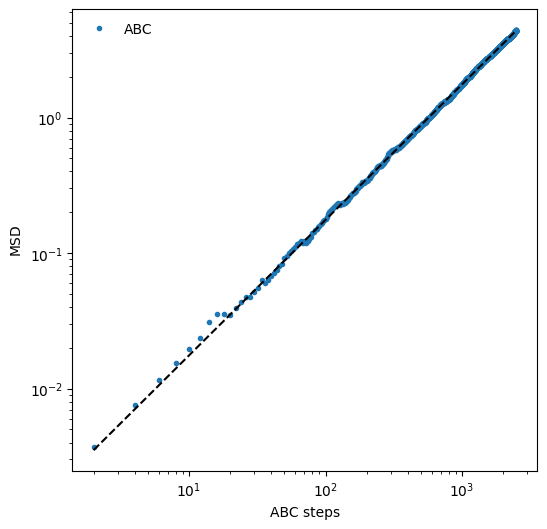

diffusivity: 0.0002928689015715955 A^2/step
vacancy jump distance: 2.91582534825298 A/step
vacancy jump distance: 1.0182984943846445 d_Al


In [5]:
timestep = 1

# do curve fitting to get slope
x = np.vstack([t_list[1:]*timestep,np.ones_like(t_list[1:]*timestep)]).T 
y = msd[1:]
A, B = np.linalg.lstsq(x, y, rcond=None)[0]    

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1,1,1)

ax.plot(t_list[1:]*timestep,msd[1:],".", label="ABC")
ax.plot(t_list[1:]*timestep, A*t_list[1:]*timestep, "--k")


ax.set_xscale("log")
ax.set_yscale("log")
# ax.set_ylim([1e-1,10])
# ax.set_xlim([1,1e4])

ax.set_xlabel(r"ABC steps")
ax.set_ylabel(r"$\rm{MSD}$")
ax.legend(frameon=False)
plt.show()

diffusivity = A/6
print(f"diffusivity: {diffusivity} A^2/step")
d_vacancy = np.sqrt(A*2047/((1-1/12)/(1+1/12))*12/6)
print(f"vacancy jump distance: {d_vacancy} A/step")
print(f"vacancy jump distance: {d_vacancy/4.0495*np.sqrt(2)} d_Al")

In [6]:
((1-1/12)/(1+1/12))

0.8461538461538461